12:34:28 - cmdstanpy - INFO - Chain [1] start processing
12:34:28 - cmdstanpy - INFO - Chain [1] done processing


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 285ms/step

 Model Performance Summary:
ARIMA: MAE = 12.239, RMSE = 14.172
Prophet: MAE = 14.431, RMSE = 16.172
LSTM: MAE = 13.318, RMSE = 15.895

 Best Model: ARIMA (saved as 'best_pollution_model.pkl')


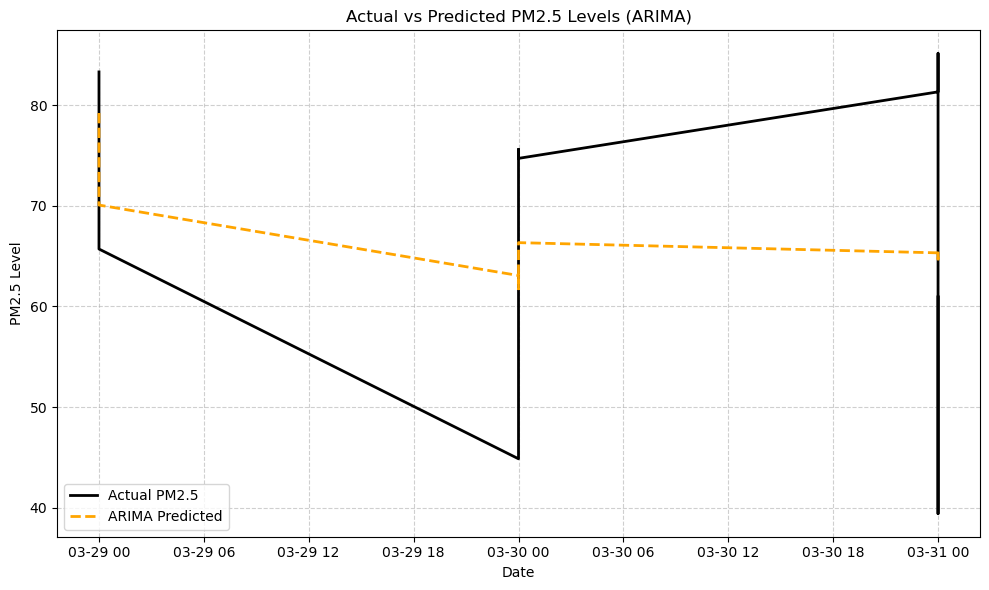

All models trained, evaluated, and best one saved successfully.


In [9]:
# Import Required Libraries

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.metrics import mean_absolute_error, mean_squared_error
from statsmodels.tsa.arima.model import ARIMA
from prophet import Prophet
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Dense
from tensorflow.keras.callbacks import EarlyStopping
import pickle
import warnings
warnings.filterwarnings("ignore")


# Load and Preprocess Data
df = pd.read_csv("synthetic_pollution_data_with_missing.csv")
df['Date'] = pd.to_datetime(df['Date'])

# Handle missing values using forward/backward fill
df['PM2.5'] = df['PM2.5'].fillna(method='ffill').fillna(method='bfill')
df['PM10'] = df['PM10'].fillna(method='ffill').fillna(method='bfill')

# Sort by date to maintain time order
df = df.sort_values(by='Date').reset_index(drop=True)


#  Create Lag Features for Modeling
def create_lag_features(data, lags=[1, 2, 3]):
    df_lag = data.copy()
    for lag in lags:
        df_lag[f'PM2.5_lag{lag}'] = df_lag['PM2.5'].shift(lag)
    df_lag.dropna(inplace=True)
    return df_lag

df = create_lag_features(df)

#  Train Data
train = df[:-10]
test = df[-10:]

X_train = train[[col for col in df.columns if 'lag' in col]]
X_test = test[[col for col in df.columns if 'lag' in col]]
y_train = train['PM2.5']
y_test = test['PM2.5']

# Evaluation

def evaluate_model(y_true, y_pred):
    mae = mean_absolute_error(y_true, y_pred)
    rmse = np.sqrt(mean_squared_error(y_true, y_pred))
    return mae, rmse
results = {}

# ARIMA
try:
    arima_model = ARIMA(y_train, order=(3, 1, 2)).fit()
    arima_pred = arima_model.forecast(steps=len(y_test))
    mae, rmse = evaluate_model(y_test, arima_pred)
    results['ARIMA'] = {'model': arima_model, 'MAE': mae, 'RMSE': rmse, 'predictions': arima_pred}
except Exception as e:
    print(f"ARIMA failed: {e}")

# Prophet 
try:
    prophet_df = df[['Date', 'PM2.5']].rename(columns={'Date': 'ds', 'PM2.5': 'y'})
    prophet_model = Prophet()
    prophet_model.fit(prophet_df[:-10])
    future = prophet_model.make_future_dataframe(periods=10)
    forecast = prophet_model.predict(future)
    prophet_pred = forecast['yhat'].iloc[-10:].values
    mae, rmse = evaluate_model(y_test, prophet_pred)
    results['Prophet'] = {'model': prophet_model, 'MAE': mae, 'RMSE': rmse, 'predictions': prophet_pred}
except Exception as e:
    print(f"Prophet failed: {e}")

#LSTM 
try:
    X_train_lstm = np.array(X_train).reshape((X_train.shape[0], X_train.shape[1], 1))
    X_test_lstm = np.array(X_test).reshape((X_test.shape[0], X_test.shape[1], 1))

    lstm_model = Sequential([
        LSTM(64, activation='relu', input_shape=(X_train_lstm.shape[1], 1)),
        Dense(1)
    ])
    lstm_model.compile(optimizer='adam', loss='mse')
    lstm_model.fit(X_train_lstm, y_train, epochs=30, batch_size=8, verbose=0,
                   callbacks=[EarlyStopping(patience=5, restore_best_weights=True)])

    lstm_pred = lstm_model.predict(X_test_lstm).flatten()
    mae, rmse = evaluate_model(y_test, lstm_pred)
    results['LSTM'] = {'model': lstm_model, 'MAE': mae, 'RMSE': rmse, 'predictions': lstm_pred}
except Exception as e:
    print(f"LSTM failed: {e}")


# Compare Models and Save Best One

print("\n Model Performance Summary:")
for name, res in results.items():
    print(f"{name}: MAE = {res['MAE']:.3f}, RMSE = {res['RMSE']:.3f}")

# Select best model by lowest RMSE
best_model_name = min(results, key=lambda k: results[k]['RMSE'])
best_model = results[best_model_name]['model']

# Save best model for inference
with open('best_pollution_model.pkl', 'wb') as f:
    pickle.dump(best_model, f)

print(f"\n Best Model: {best_model_name} (saved as 'best_pollution_model.pkl')")


# Improved Forecast Visualization 
plt.figure(figsize=(10,6))
plt.plot(test['Date'], y_test.values, label='Actual PM2.5', color='black', linewidth=2)
plt.plot(test['Date'], results[best_model_name]['predictions'],
         label=f'{best_model_name} Predicted', linestyle='--', color='orange', linewidth=2)
plt.xlabel("Date")
plt.ylabel("PM2.5 Level")
plt.title(f"Actual vs Predicted PM2.5 Levels ({best_model_name})")
plt.legend()
plt.grid(True, linestyle='--', alpha=0.6)
plt.tight_layout()
plt.show()

print("All models trained, evaluated, and best one saved successfully.")

    





